## Summary
1. .
2. .
3. .
- 3 trends
...
- maybe recode the mouse_id to be an integer? 

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

In [5]:
drugsdf = pd.read_csv('raw_data/mouse_drug_data.csv')
tumors = pd.read_csv('raw_data/clinicaltrial_data.csv')

## Preprocessing

In [33]:
data = pd.merge(drugsdf, tumors, how='inner')

data = data.rename(columns={\
                            'Mouse ID': 'mouse_id',\
                            'Tumor Volume (mm3)': 'tumor_vol',\
                            'Metastatic Sites': 'mets'})

drugs = ['Capomulin', 'Infubinol', 'Ketapril', 'Placebo']
mask_drugs = data['Drug'].isin(drugs)


data_drugs = data[mask_drugs]

## Tumor Volume
Scatter plot: tumor volume changes over time for each treatment 

In [7]:
capomulin = data[data.Drug == "Capomulin"]
infubinol = data[data.Drug == "Infubinol"]
ketapril = data[data.Drug == "Ketapril"]
placebo = data[data.Drug == "Placebo"]

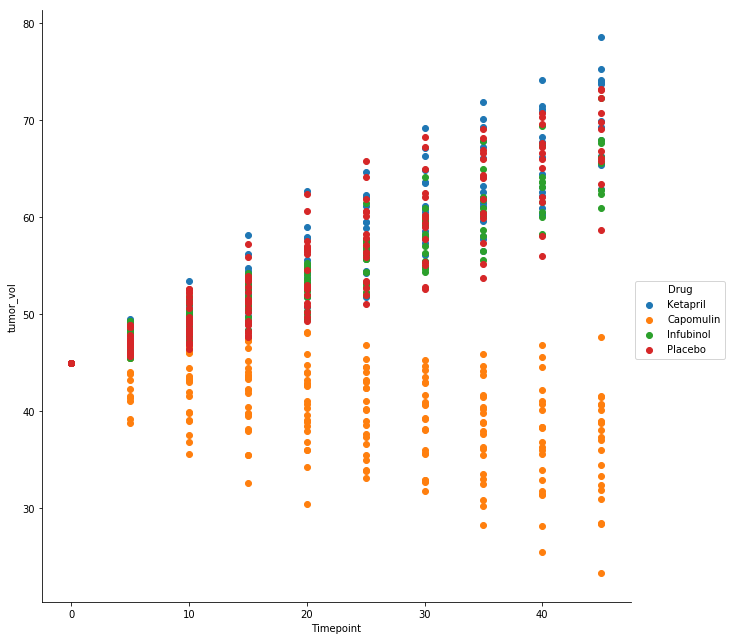

In [8]:
sns.FacetGrid(data_drugs, hue="Drug", size=9,) \
   .map(plt.scatter, "Timepoint", "tumor_vol") \
   .add_legend();

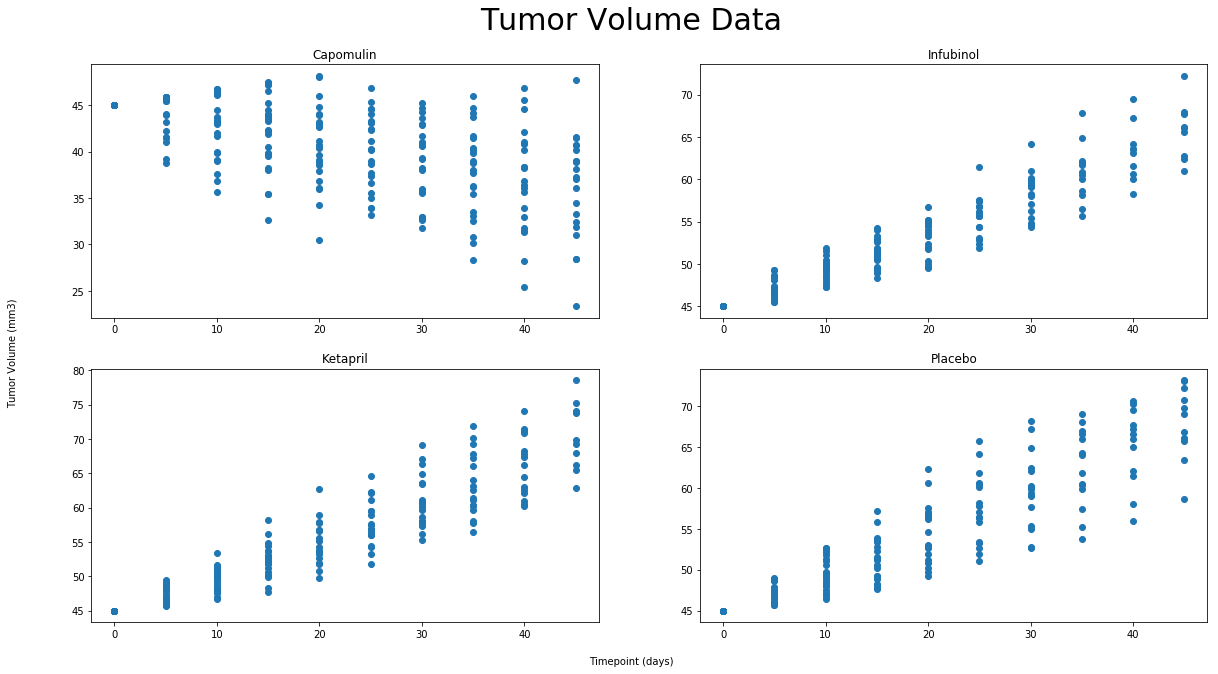

In [32]:
tumorfig = plt.figure(figsize=(20, 10))

axes1 = tumorfig.add_subplot(2, 2, 1)
axes2 = tumorfig.add_subplot(2, 2, 2)
axes3 = tumorfig.add_subplot(2, 2, 3)
axes4 = tumorfig.add_subplot(2, 2, 4)

axes1.plot(capomulin['Timepoint'], capomulin['tumor_vol'], 'o')
axes2.plot(infubinol['Timepoint'], infubinol['tumor_vol'], 'o')
axes3.plot(ketapril['Timepoint'], ketapril['tumor_vol'], 'o')
axes4.plot(placebo['Timepoint'], placebo['tumor_vol'], 'o')

axes1.set_title("Capomulin")
axes2.set_title("Infubinol")
axes3.set_title("Ketapril")
axes4.set_title("Placebo")

tumorfig.text(0.5, 0.07, 'Timepoint (days)', ha='center', va='center')
tumorfig.text(0.07, 0.5, 'Tumor Volume (mm3)', ha='center', va='center', rotation='vertical')

tumorfig.subplots_adjust(top=0.90)
tumorfig.suptitle("Tumor Volume Data", fontsize=30);

## METASTASES
Scatter plot: number of metastatic sites - changes over time for each treatment

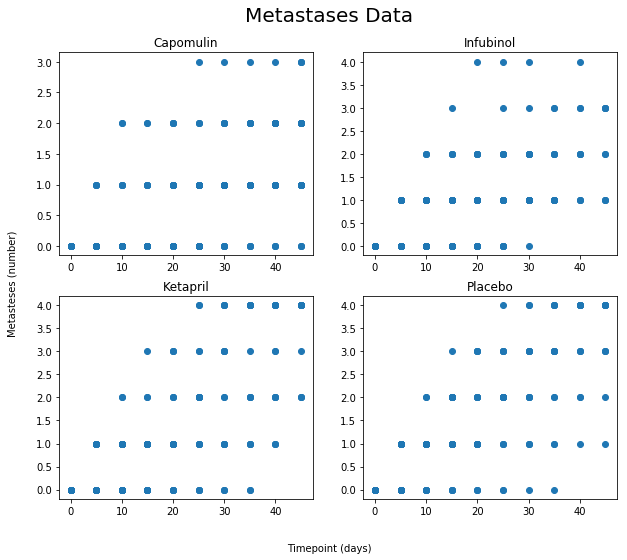

In [26]:
metfig = plt.figure(figsize=(10, 8))

axes1 = metfig.add_subplot(2, 2, 1)
axes2 = metfig.add_subplot(2, 2, 2)
axes3 = metfig.add_subplot(2, 2, 3)
axes4 = metfig.add_subplot(2, 2, 4)

axes1.plot(capomulin['Timepoint'], capomulin['mets'], 'o')
axes2.plot(infubinol['Timepoint'], infubinol['mets'], 'o')
axes3.plot(ketapril['Timepoint'], ketapril['mets'], 'o')
axes4.plot(placebo['Timepoint'], placebo['mets'], 'o')

axes1.set_title("Capomulin")
axes2.set_title("Infubinol")
axes3.set_title("Ketapril")
axes4.set_title("Placebo")

metfig.text(0.5, 0.04, 'Timepoint (days)', ha='center', va='center')
metfig.text(0.06, 0.5, 'Metasteses (number)', ha='center', va='center', rotation='vertical')

metfig.subplots_adjust(top=0.90)
metfig.suptitle("Metastases Data", fontsize = 20);

## SURVIVAL RATE

Scatter plot: number of mice still alive through the course of treatment

In [37]:
subjects = data_drugs.groupby('mouse_id')

subjects_time = subjects['Timepoint']

In [17]:
## Need the columns for observed and duration
# for x if data_drugs.query('Timepoint == 45'). groupby mice? aggregate? sum observed? 
#right. we don't want this on data_drugs. need to just make a new df like for the bar graph
data_drugs['observed'] = np.where(data_drugs['Timepoint'] == 45, '1', '0')
#########?

In [ ]:
duration = subjects.Timepoint.last() - subjects.Timepoint.first()

In [ ]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [ ]:
T = data_drugs["duration"]
E = data_drugs["observed"]

kmf.fit(T, event_observed=E)

In [ ]:
kmf.survival_function_.plot()
plt.title('Survival function of political regimes');

In [ ]:
kmf.plot()

In [ ]:
ax = plt.subplot(111)

cap = (data_drugs["Drug"] == "Capomulin")
kmf.fit(T[cap], event_observed=E[cap], label="Capomulin")
kmf.plot(ax=ax, ci_force_lines=True)
kmf.fit(df[~cap], event_observed=E[~cap], label="Others")
kmf.plot(ax=ax, ci_force_lines=True)

plt.ylim(0, 1);
plt.title("Lifespans of mice on different drugs");

## Total % Tumor Volume Change
- Bar Graph - total % tumor volume change for each drug across the full 45 days.
- http://cancerres.aacrjournals.org/content/canres/suppl/2012/07/30/0008-5472.CAN-12-0954.DC1/tab2.pdf - Uses initial and final volume. Takes mean, sd, sterrr for the % changes

In [44]:
tumor_vol_change_per_mouse = 100*((subjects.tumor_vol.first() - subjects.tumor_vol.last())\
                                  / subjects.tumor_vol.first())

In [45]:
tumor_vol_change_per_mouse = tumor_vol_change_per_mouse.to_frame()
tumor_vol_change_per_mouse = tumor_vol_change_per_mouse.reset_index()

#drugsdf comes from initial read_csv 
drugsdf = drugsdf.rename(columns={'Mouse ID': 'mouse_id',})
drugsdf = drugsdf.sort_values('mouse_id')

tumor_vol_drug_data = pd.merge(drugsdf, tumor_vol_change_per_mouse, on='mouse_id')

In [46]:
tumor_vol_drug_data.head()

,mouse_id,Drug,tumor_vol
0,a203,Infubinol,-51.052042
1,a251,Infubinol,-45.612762
2,a262,Placebo,-57.150268
3,a457,Ketapril,-10.629820
4,a577,Infubinol,-26.737471


In [47]:
drug_group = tumor_vol_drug_data.groupby('Drug')['tumor_vol']

#total tumor drug volume 
ttdv = drug_group.mean()
ttdv = ttdv.to_frame()

#tumor change in volume
tcv = tumor_vol_drug_data['tumor_vol'].tolist()

In [48]:
cap_vc = tumor_vol_drug_data[tumor_vol_drug_data.Drug == "Capomulin"]
inf_vc = tumor_vol_drug_data[tumor_vol_drug_data.Drug == "Infubinol"]
ket_vc = tumor_vol_drug_data[tumor_vol_drug_data.Drug == "Ketapril"]
plac_vc = tumor_vol_drug_data[tumor_vol_drug_data.Drug == "Placebo"]

In [49]:
drug_sems = [stats.sem(cap_vc.tumor_vol), stats.sem(inf_vc.tumor_vol), stats.sem(ket_vc.tumor_vol), stats.sem(plac_vc.tumor_vol)]

In [50]:
drug_sems

[2.5400837010803543, 3.3577725046093874, 4.420408998458811, 3.9442985072748358]

In [51]:
ttdv['error'] = drug_sems

In [52]:
ttdv

,tumor_vol,error
Drug,,
Capomulin,18.516516,2.540084
Infubinol,-30.442222,3.357773
Ketapril,-39.569314,4.420409
Placebo,-34.463143,3.944299


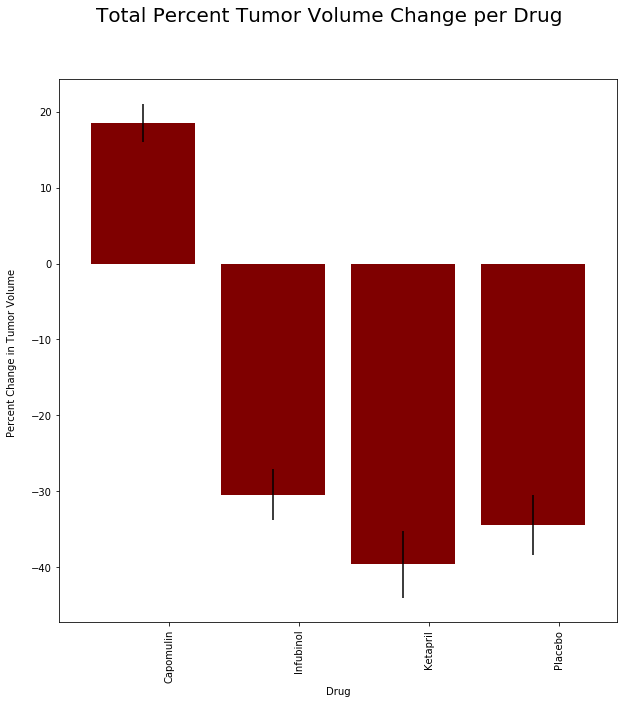

In [55]:
fig, ax = plt.subplots()

tvplot = ttdv['tumor_vol'].plot(kind='bar',yerr=ttdv["error"],colormap='OrRd_r',\
                              grid=False,figsize=(10,10),ax=ax,position=0.75,\
                              error_kw=dict(ecolor='black',elinewidth=1.5),width=0.8)

fig.text(0.06, 0.5, 'Percent Change in Tumor Volume', ha='center', va='center', rotation='vertical')
fig.suptitle("Total Percent Tumor Volume Change per Drug", fontsize = 20)

plt.show()
#the negative percent change means the tumor volume increased. 